# Emotion extraction system（VAD : Valence, Arousal, Dominance）

このプログラムは音声のデータから、Valence（快-不快）,Arousal（覚醒-睡眠）, Dominance（支配-服従）の3つ要素を推定し、これら３つの変数の値から感情を予測する。

## 0. 分析するデータの指定

In [122]:
# 分析結果を格納するフォルダの選択・作成
output_file = "emo&var05_model_results_samplevoice_soxshudou01"
# 分析対象のデータの選択
file_csv = "samplevoice_soxsyudou.csv"

## 1. 分析対象のデータの詳細設定

In [123]:
# ファイルをどう解析した以下によって変数の値を変える
section = 1 # 発話ごと区切られたデータなのか = 1:yes, 0:no 
y = 2 # 発話を時系列順に何分割するのか = 1 or 2 or 3 or 4 or...
first_con_ag = 0 # 一発話目を感情の平常だと考え、VADの値を0.5にスケールを調整するか = 1:yes, 0:no

## 2. 分析

### 2.1 ライブラリのインポート

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc

from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from keras.models import load_model
from scipy import stats

### 2.2 パスの設定

In [125]:
model_name = "model_emo&var05_" # モデルの名前
model_path = 'results/allemo_laughter_cv_results_emo&var05/' # 学習モデルが格納されているファイルパス
Valence_model = model_path + 'model_IEMOCAP_allemo_cv_laughter_No.5_Valence.hdf5' # 実際の学習モデル（Valence）
Arousal_model = model_path + 'model_IEMOCAP_allemo_cv_laughter_No.5_Arousal.hdf5'
Dominance_model = model_path + 'model_IEMOCAP_allemo_cv_laughter_No.5_Dominance.hdf5'

input_path = "input_file/" # 入力データが格納されているファイルパス
input_file = [file_csv, "emotest_all_11k_IS09_emotion_Normalized_20210617.csv", "var_collect_IS09_Normalized.csv"] # IEMOCAPとUUDBは特徴量の値を 0 - 1 にスケーリングするのに使用
x_param_list = [] # 空の特徴量リストを作成

### 2.3 関数の定義

In [126]:
def make_dir(output_file='test00'):
    """
        フォルダがあるかの確認・なければ作成
    """
    output_path = 'results/' + output_file + '/'
    pwd = os.getcwd()
    output_path_full = pwd + "/" + output_path
    if os.path.isdir(output_path_full):
        print('output path : ' + output_path_full)
    else:
        os.mkdir(output_path)
        print('output path : ' + output_path_full)
    return output_path

In [127]:
def make_features(input_path="input_file/", feature_file1="openSmile_namelist.csv", feature_file2='openSmile_namelist_narrowed_down.csv'):
    """
        特徴量リストの作成
    """
    # 使用するOpenSmileの入力パラメータの名前リスト（param_list）の作成
    namelist_csv = input_path + feature_file1  # F0_sma_minは０ばかりなので抜いた
    df_namelist = pd.read_csv(namelist_csv, header=0, index_col=None) # 0行目をヘッダーに設定

    x_param_list = df_namelist["param"] # 入力データのパラメータ名
    y_param_list = ["Valence", "Arousal", "Dominance"]# 出力データのパラメータ名
    x_param_list_flag = list(pd.read_csv(input_path + feature_file2, header=0, index_col=None)['param']) # 絞り込んだ特徴量のリスト

    return x_param_list, x_param_list_flag, y_param_list

In [128]:
def formula(x):
    """
        emotion tagという数値情報をraw dataに追加
    """
    emotion_dict = {"neu":0, "hap":1, "sad":2, "ang":3, "sur":4, "fea":5, "fru":6, "exc":7,"oth":8,"xxx":8}
    if x in emotion_dict:
        return emotion_dict[x]
    else:
        return 9  #oth,xxxの場合は、emotion tag=8

In [129]:
def selectdata_normalized(input_path="input_file/", input_file=[file_csv, "emotest_all_11k_IS09_emotion_Normalized_20210617.csv", "var_collect_IS09_Normalized.csv"]):
    """
        データの読み込みと学習時に用いたデータを使い特徴量の値を 0 - 1 に揃えるために学習に用いたデータと分析データを全てに縦に結合する
    """
    # データの読み込み
    input_csv = input_path + input_file[0]
    df = pd.read_csv(input_csv, header=0, index_col=0)  # input_csv読み込み

    # データの結合
    df_all_x = df[x_param_list]
    for files in input_file[1::]:
        df_other = pd.read_csv(input_path + files, header=0, index_col=0)
        df_all_x = pd.concat([df_other[x_param_list], df_all_x[x_param_list]])
        
    print("df.shape = ", df.shape)
    print("df_all_x.shape = ", df_all_x.shape)
    return df, df_all_x

In [130]:
def answer_normalization(df_raw, input_file=[file_csv, "emotest_all_11k_IS09_emotion_Normalized_20210617.csv", "var_collect_IS09_Normalized.csv"]):
    """
        正解ラベル持っているファイルに対して、正解ラベルを整えて 0 - 1 の範囲に正規化を行う
    """
    df = df_raw.copy()
    if input_file[0]=="emotest_all_11k_IS09_emotion_Normalized_20210617.csv" or input_file[0]=="emotest_all_11k_IS09_emotion_uc_20201201.csv":
        print("This data has answer's label")
        for i in y_param_list:
            df.loc[df[i] < 1.0, i] = 1.0
            df.loc[df[i] > 5.0, i] = 5.0
            print("df[{0}].max = {1}".format(i, df["{}".format(i)].max()))
            print("df[{0}].min = {1}".format(i, df["{}".format(i)].min()))
        df["Valence(0-1)"] = (df["Valence"] - 1) / (5 - 1) # 0-1に正規化
        df["Arousal(0-1)"] = (df["Arousal"] - 1) / (5 - 1) # 0-1に正規化
        df["Dominance(0-1)"] = (df["Dominance"] - 1) / (5 - 1) # 0-1に正規化
        for i in y_param_list:
            print("df[{0}].max = {1}".format(i+"(0-1)", df["{}".format(i+"(0-1)")].max()))
            print("df[{0}].min = {1}".format(i+"(0-1)", df["{}".format(i+"(0-1)")].min()))
    elif input_file[0]=="var_collect_IS09_Normalized.csv" or input_file[0]=="var_collect_IS09_NoNormalized.csv":
        print("This data has answer's label")
        for i in y_param_list:
            df.loc[df[i] < 1.0, i] = 1.0
            df.loc[df[i] > 7.0, i] = 7.0
            print("df[{0}].max = {1}".format(i, df["{}".format(i)].max()))
            print("df[{0}].min = {1}".format(i, df["{}".format(i)].min()))
        df["Valence(0-1)"] = (df["Valence"] - 1) / (7 - 1) # 0-1に正規化
        df["Arousal(0-1)"] = (df["Arousal"] - 1) / (7 - 1) # 0-1に正規化
        df["Dominance(0-1)"] = (df["Dominance"] - 1) / (7 - 1) # 0-1に正規化
        for i in y_param_list:
            print("df[{0}].max = {1}".format(i+"(0-1)", df["{}".format(i+"(0-1)")].max()))
            print("df[{0}].min = {1}".format(i+"(0-1)", df["{}".format(i+"(0-1)")].min()))
    else:
        print("This data is no label data")
    return df

In [131]:
def make_emotion(df_raw):
    """
        データフレームに 'emo' と 'emotion' というカラムを作成
    """
    df = df_raw.copy()
    if "emo" in df.columns:
        pass
    else:
        df["emo"] = np.nan
    # df["emotion"] = df.apply(lambda row: formula(row["emo"]), axis=1) # 別の書き方
    df["emotion"] = df["emo"].apply(lambda row: formula(row)) # 上記で作成した'formula'関数を利用して'emotion'列を作成
    print("df_after.shape = ", df.shape)
    return df

In [132]:
def predict_vad(df, y_param_list=['Valence', 'Arousal', 'Dominance'], param=x_param_list):
    """
        VADの予測と、正解ラベルとの比較
    """

    df_out_cmp = pd.DataFrame(index=[])
    df_out_ans = pd.DataFrame(index=[])
    df_out_pre = pd.DataFrame(index=[])

    for item in y_param_list:
        print(item)

        X_df = (df[param] - df_all_x[param].min()) / (df_all_x[param].max() - df_all_x[param].min())  # パラメータ毎にMin/Maxを0-1スケーリング

        cvcorr = []
        cvscores = []

        #print("number of dataset =",len(df))
        #print("shape of X_df",X_df.shape)
            
        #＜モデルを読み込む＞
        #保存したファイル.hdf5を選択
        if item == 'Arousal':
            learning_model = Arousal_model
        elif item == 'Dominance':
            learning_model = Dominance_model
        elif item == 'Valence':
            learning_model = Valence_model
        model = load_model(learning_model)
        print("model = {}".format(learning_model))

        #＜モデルの詳細＞  
        #model.summary()

        #＜推論＞
        Y_predict1 = model.predict(X_df)
        df_out = pd.DataFrame(Y_predict1, index=df.index, columns=["Y_predict"])
        df_out_pre["{}".format(item)] = df_out["Y_predict"]
        df_out_cmp = df_out_pre

        # ＜学習結果の確認＞
        # 正解ラベルがある場合、相関係数と決定係数の確認
        if item in df.columns:
            Y_df = df["{}(0-1)".format(item)]
            #print("shape of Y_df",Y_df.shape)
            df_out["Y_df"] = Y_df
            corr, p = pearsonr(df_out["Y_df"], df_out["Y_predict"])
            r2 = r2_score(df_out["Y_df"], df_out["Y_predict"])
            cvcorr.append(corr)
            print("corr = ", corr)
            cvscores.append(r2)
            print("cvscores = ", r2)
            print("")
            sns.jointplot(x="Y_df", y="Y_predict", data=df_out, kind='reg', xlim=(0, 1), ylim=(0, 1))
            plt.suptitle("corr={:.3g} / p={:.3g} / R^2={:.3g}".format(corr, p, r2))
            plt.savefig(output_path + file_csv.split('.')[0] + "_{}_corr_r2.png".format(item))
            plt.cla()  # Axesをクリア
            plt.clf()  # figureをクリア
            plt.close()  # pltを閉じる
            #出力csv file
            cvcorr = pd.DataFrame(cvcorr, columns=['corr'])
            # cvcorr.to_csv(output_path + "corr_{}.csv".format(item))
            cvscores = pd.DataFrame(cvscores, columns=['r2'])#, 'predict_value','iemocap', 'iemocapvalue'])#, index=list_rowname)
            # cvscores.to_csv(output_path + "r2_{}.csv".format(item))#, index=True, header=True)
            df_out_ans["ans_{}".format(item)] = df_out["Y_df"]
            df_out_cmp = pd.concat([df_out_pre, df_out_ans], axis=1)
        else:
            pass

        gc.collect()
        print('>> Finished predict')
        print('--------------------------------------------------------------------------------------')

    df_out_cmp.to_csv(output_path + file_csv.split('.')[0] + "_vad.csv")
    return df_out_cmp

### 2.4 VADの予測

In [133]:
output_path = make_dir(output_file)

output path : /Users/master/Desktop/アーカイブ/共同研究（音声）/IEMOCAP_NN/results/emo&var05_model_results_samplevoice_soxshudou01/


In [134]:
x_param_list, x_param_list_flag, y_param_list = make_features(input_path)

In [135]:
df_raw, df_all_x = selectdata_normalized(input_path, input_file)

df.shape =  (15, 384)
df_all_x.shape =  (14894, 383)


In [136]:
df = answer_normalization(df_raw, input_file)

This data is no label data


In [137]:
df = make_emotion(df)

df_after.shape =  (15, 386)


In [138]:
df

,pcm_RMSenergy_sma_max,pcm_RMSenergy_sma_min,pcm_RMSenergy_sma_range,pcm_RMSenergy_sma_maxPos,pcm_RMSenergy_sma_minPos,pcm_RMSenergy_sma_amean,pcm_RMSenergy_sma_linregc1,pcm_RMSenergy_sma_linregc2,pcm_RMSenergy_sma_linregerrQ,pcm_RMSenergy_sma_stddev,...,F0_sma_de_minPos,F0_sma_de_amean,F0_sma_de_linregc1,F0_sma_de_linregc2,F0_sma_de_linregerrQ,F0_sma_de_stddev,F0_sma_de_skewness,F0_sma_de_kurtosis,emo,emotion
name,,,,,,,,,,,,,,,,,,,,,
'iroiro_higurashi_001.wav',0.06190,0.000240,0.06160,77.0,1.0,0.01650,-1.020000e-04,0.02310,0.000205,0.01480,...,41.0,-8.340000e-08,-0.15800,10.200,983.0,31.90,0.09360,7.19,NaN,9
'iroiro_higurashi_002.wav',0.06430,0.000137,0.06420,251.0,0.0,0.01510,1.100000e-07,0.01500,0.000198,0.01410,...,116.0,2.600000e-08,-0.02350,4.150,2040.0,45.20,-0.11100,3.98,NaN,9
'iroiro_higurashi_003.wav',0.08520,0.000153,0.08510,170.0,70.0,0.01300,1.240000e-04,0.00115,0.000147,0.01390,...,59.0,-4.450000e-08,-0.00316,0.302,74.8,8.65,0.01420,26.20,NaN,9
'iroiro_higurashi_004.wav',0.02990,0.000287,0.02960,83.0,129.0,0.00408,1.320000e-05,0.00323,0.000024,0.00496,...,96.0,1.520000e-07,-0.05200,3.360,1010.0,31.90,-0.13100,9.00,NaN,9
'iroiro_higurashi_005.wav',0.04530,0.000280,0.04500,66.0,51.0,0.01010,7.490000e-05,0.00647,0.000125,0.01140,...,29.0,-3.890000e-08,-0.00732,0.355,77.3,8.80,-0.05960,15.80,NaN,9
'iroiro_higurashi_006.wav',0.06380,0.000355,0.06340,36.0,0.0,0.01820,1.830000e-05,0.01640,0.000223,0.01500,...,50.0,1.400000e-08,-0.00653,0.624,305.0,17.50,0.00602,6.11,NaN,9
'iroiro_higurashi_007.wav',0.06160,0.000477,0.06110,12.0,22.0,0.01810,-2.540000e-04,0.03030,0.000187,0.01540,...,45.0,3.690000e-08,-0.05700,2.730,291.0,17.10,-0.88000,12.50,NaN,9
'iroiro_higurashi_008.wav',0.11100,0.000564,0.11000,106.0,197.0,0.03010,-3.160000e-05,0.03350,0.000610,0.02480,...,173.0,1.620000e-08,-0.00836,0.903,481.0,21.90,-0.33700,8.03,NaN,9
'iroiro_higurashi_009.wav',0.02740,0.000285,0.02710,9.0,52.0,0.01030,-1.990000e-04,0.02030,0.000044,0.00880,...,10.0,-4.010000e-08,-0.06370,3.180,1030.0,32.10,0.03210,3.87,NaN,9


In [139]:
df_out_cmp = predict_vad(df, y_param_list=y_param_list, param=x_param_list)

Valence
model = results/allemo_laughter_cv_results_emo&var05/model_IEMOCAP_allemo_cv_laughter_No.5_Valence.hdf5


2022-05-17 14:44:18.583798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


>> Finished predict
--------------------------------------------------------------------------------------
Arousal
model = results/allemo_laughter_cv_results_emo&var05/model_IEMOCAP_allemo_cv_laughter_No.5_Arousal.hdf5


2022-05-17 14:44:18.960211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


>> Finished predict
--------------------------------------------------------------------------------------
Dominance
model = results/allemo_laughter_cv_results_emo&var05/model_IEMOCAP_allemo_cv_laughter_No.5_Dominance.hdf5
>> Finished predict
--------------------------------------------------------------------------------------


2022-05-17 14:44:19.334572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [140]:
df_out_cmp

,Valence,Arousal,Dominance
name,,,
'iroiro_higurashi_001.wav',0.772614,0.793260,0.804540
'iroiro_higurashi_002.wav',0.690431,0.867359,0.737721
'iroiro_higurashi_003.wav',0.485323,0.614954,0.673315
'iroiro_higurashi_004.wav',0.523401,0.864825,0.626685
'iroiro_higurashi_005.wav',0.550778,0.556022,0.526123
'iroiro_higurashi_006.wav',0.460157,0.609133,0.574562
'iroiro_higurashi_007.wav',0.722560,0.741564,0.604771
'iroiro_higurashi_008.wav',0.519585,0.742112,0.783674
'iroiro_higurashi_009.wav',0.345792,0.662298,0.646616


## 3. 発話ごとの分析

# ここまで整理した↑

In [141]:
def first_conversation_averaging(flag=first_con_ag, df=pd.DataFrame(), count_index=1):
    """
        会話の一番初めの発話が Valence=0.5, Arousal=0.5, Dominance=0.5 になるように平均化を行う
    """
    grouped = df.groupby('count_index')
    df_out_cmp_fca = df_out_cmp.copy()
    if flag == 1:
        df_group_mean = pd.DataFrame()
        for i in range(1,count_index+1):
            group_mean = grouped.get_group(i).iloc[0]
            df_group_mean_sub = (((grouped.get_group(i)- group_mean) + 1)/2)[["Valence", "Arousal", "Dominance"]]
            df_group_mean_sub.astype('float')
            df_group_mean_sub['count_index'] = i
            df_group_mean = pd.concat([df_group_mean, df_group_mean_sub])

        df_group_mean[["Valence", "Arousal", "Dominance"]] = df_group_mean[["Valence", "Arousal", "Dominance"]].astype('float64')
        df_group_mean.index.name = 'name'
        df_group_mean[["Valence", "Arousal", "Dominance"]].to_csv(output_path + file_csv.split('.')[0] + "_first_conversation_avg.csv")
        df_out_cmp_fca = df_group_mean[["Valence", "Arousal", "Dominance"]]
        grouped = df_group_mean.groupby('count_index')
    return df_out_cmp_fca, grouped

In [142]:
def utterance_processing(df_sox=df_out_cmp):
    """
        発話ごと区切られているデータの場合、そのデータを会話ごとにラベリングとグルーピングを行う
    """
    df_group_label = pd.DataFrame(index=list(df_sox.index), columns=['count_index'])
    count_index = 0 # 発話ではなく、会話に分けた時の音声ファイル数を数える（ラベル付）用
    names = [] # 音声ファイルのファイル名を保存するリスト（'音声ファイル名_001.wav' の '音声ファイル名' の部分）
    for i in df_sox.index:
        numbers = int(i.rsplit('_',1)[1].rsplit('.')[0])
        if numbers == 1:
            count_index = count_index + 1
            names.append(i.rsplit('_',1)[0] + "'")
            df_group_label.loc[i].count_index = count_index
        else:
            df_group_label.loc[i].count_index = count_index
    df_out_cmp_2 = pd.concat([df_sox, df_group_label], axis=1)
    df_out_cmp, grouped = first_conversation_averaging(first_con_ag, df_out_cmp_2, count_index)
    return df_out_cmp, df_out_cmp_2, grouped, names, count_index

In [143]:
def utterance_describe(names, count_inedex):
    """
        発話ごとのデータに対して、それぞれを会話単位にグルーピングしたものを利用してVADに以下の処理を行う
        処理内容：
            平均
            中央値
            相関係数
            傾き
            切片
    """
    df_out_cmp_mean = pd.DataFrame(index=names, columns=['Valence_mean','Arousal_mean','Dominance_mean'])
    df_group = grouped.mean()
    df_out_cmp_median = pd.DataFrame(index=names, columns=['Valence_median','Arousal_median','Dominance_median'])
    df_group_median = grouped.median()
    
    for i in range(len(df_out_cmp_mean.index)):
        df_out_cmp_mean.iloc[i] = df_group.iloc[i]
        
    for i in range(len(df_out_cmp_median.index)):
        df_out_cmp_median.iloc[i] = df_group_median.iloc[i]
    
    df_out_cmp_mean = pd.concat([df_out_cmp_mean, df_out_cmp_median], axis = 1)
        
    df_out_cmp_describe = pd.DataFrame(index=names, columns=['V-A_corr','V-A_slope','V-A_intercept','V-D_corr','V-D_slope','V-D_intercept','A-D_corr','A-D_slope','A-D_intercept'])
    for i in range(1,count_index+1):
        if len(grouped.get_group(i)) == 1:
            va_slope, va_intercept, va_corr = np.nan,np.nan,np.nan
            vd_slope, vd_intercept, vd_corr = np.nan,np.nan,np.nan
            ad_slope, ad_intercept, ad_corr = np.nan,np.nan,np.nan
        else:
            va_slope, va_intercept, va_corr, _, _ = stats.linregress(grouped.get_group(i).Valence, grouped.get_group(i).Arousal)
            vd_slope, vd_intercept, vd_corr, _, _ = stats.linregress(grouped.get_group(i).Valence, grouped.get_group(i).Dominance)
            ad_slope, ad_intercept, ad_corr, _, _ = stats.linregress(grouped.get_group(i).Arousal, grouped.get_group(i).Dominance)
    
        df_out_cmp_describe.iloc[i-1] = [va_corr, va_slope, va_intercept, vd_corr, vd_slope, vd_intercept, ad_corr, ad_slope, ad_intercept]
    
    df_out_cmp_describe = pd.concat([df_out_cmp_mean, df_out_cmp_describe], axis = 1)
    df_out_cmp_describe.index.name = 'name'
    df_out_cmp_describe
    
    df_out_cmp_describe.to_csv(output_path + "df_out_cmp_describe.csv")
    return df_group_median, df_out_cmp_describe

In [144]:
if section == 1:
    df_out_cmp, df_out_cmp_2, grouped, names, count_index = utterance_processing(df_out_cmp)
    df_group_median, df_out_cmp_describe = utterance_describe(names, count_index)
else:
    pass

In [145]:
df_out_cmp_describe

,Valence_mean,Arousal_mean,Dominance_mean,Valence_median,Arousal_median,Dominance_median,V-A_corr,V-A_slope,V-A_intercept,V-D_corr,V-D_slope,V-D_intercept,A-D_corr,A-D_slope,A-D_intercept
name,,,,,,,,,,,,,,,
'iroiro_higurashi',0.540171,0.650038,0.622591,0.523401,0.66068,0.604771,0.568639,0.706487,0.268414,0.366821,0.305638,0.457494,0.749618,0.50272,0.295804


In [146]:
#df_out_cmp_2['count_index'].value_counts()

In [147]:
#df_out_cmp_2[df_out_cmp_2["count_index"]==10]

In [148]:
import math

for i in range(1,count_index+1):
    x = grouped.get_group(i)
    split_mean_name = []
    l_empty = []
    x_counts = len(x)
    #print(x_counts)
    medi = x_counts / y
    medi_int = math.ceil(medi)
    #print(medi_int)
    for k in y_param_list:
        #print("--" + k + "--")
        sta_pos = 0
        end_pos = sta_pos + medi_int
        for j in range(y):
            if i == 1:
                split_mean_name.append(k + "_" +str(j+1)+ "_mean" )
            if end_pos >= x_counts:
                end_pos = x_counts
            split_mean = x[k][sta_pos:end_pos].mean()
            l_empty.append(split_mean)
            #print(str(sta_pos) + "," + str(end_pos))
            #print(l_empty)
            sta_pos = sta_pos + medi_int
            end_pos = end_pos + medi_int
        if i==1 and k=="Dominance":
            df_out_cmp_spmean = pd.DataFrame(index=names, columns=split_mean_name)
    df_out_cmp_spmean.iloc[i-1] = l_empty
df_out_cmp_spmean

,Valence_1_mean,Valence_2_mean,Arousal_1_mean,Arousal_2_mean,Dominance_1_mean,Dominance_2_mean
'iroiro_higurashi',0.590606,0.482531,0.723654,0.565905,0.666424,0.572497


In [149]:
df_out_cmp_spmean_diff = pd.DataFrame(index=names, columns=["Valence_"+str(y)+"-1_diff", "Arousal_"+str(y)+"-1_diff", "Dominance_"+str(y)+"-1_diff"])
for k in y_param_list:
    df_out_cmp_spmean_diff[k+"_"+str(y)+"-1_diff"] = df_out_cmp_spmean[k+"_"+ str(y) +"_mean"] - df_out_cmp_spmean[k+"_1_mean"]

df_out_cmp_spmean = pd.concat([df_out_cmp_spmean, df_out_cmp_spmean_diff], axis = 1)
df_out_cmp_spmean.index.name = 'name'
#df_out_cmp_spmean.to_csv(output_path + "df_out_cmp_spmean.csv")
df_out_cmp_spmean

,Valence_1_mean,Valence_2_mean,Arousal_1_mean,Arousal_2_mean,Dominance_1_mean,Dominance_2_mean,Valence_2-1_diff,Arousal_2-1_diff,Dominance_2-1_diff
name,,,,,,,,,
'iroiro_higurashi',0.590606,0.482531,0.723654,0.565905,0.666424,0.572497,-0.108075,-0.157749,-0.093927


In [150]:
for i in range(1,count_index+1):
    split_corr_name = []
    corr_empty = []
    g = grouped.get_group(i)
    x = np.arange(0,1.1,0.01)
    g_counts = len(g)
    if g_counts == 1:
        continue
    g_medi = g_counts / y
    g_medi_int = math.ceil(g_medi)
    if i==1:
        print(g_counts)
        print(g_medi)
        print(g_medi_int)
    
    a = df_out_cmp_describe["V-A_slope"][i-1]
    b = df_out_cmp_describe["V-A_intercept"][i-1]
    c = df_out_cmp_describe["V-A_corr"][i-1]

    sta_pos = 0
    end_pos = sta_pos + g_medi_int
    for j in range(y):
        if i == 1:
                split_corr_name.append("V"+str(j+1)+"-A"+str(j+1)+"_corr")
                split_corr_name.append("V"+str(j+1)+"-A"+str(j+1)+"_slope")
                split_corr_name.append("V"+str(j+1)+"-A"+str(j+1)+"_intercept")
                split_corr_name.append("V"+str(j+1)+"-D"+str(j+1)+"_corr")
                split_corr_name.append("V"+str(j+1)+"-D"+str(j+1)+"_slope")
                split_corr_name.append("V"+str(j+1)+"-D"+str(j+1)+"_intercept")
                split_corr_name.append("A"+str(j+1)+"-D"+str(j+1)+"_corr")
                split_corr_name.append("A"+str(j+1)+"-D"+str(j+1)+"_slope")
                split_corr_name.append("A"+str(j+1)+"-D"+str(j+1)+"_intercept")
        if end_pos >= g_counts:
            end_pos = g_counts
        if i==1:
            print(str(j+1)+":"+str(sta_pos) + "," + str(end_pos))
        #[start:stop] start <= x < stop
        va_slope, va_intercept, va_corr, _, _ = stats.linregress(g.Valence[sta_pos:end_pos], g.Arousal[sta_pos:end_pos])
        vd_slope, vd_intercept, vd_corr, _, _ = stats.linregress(g.Valence[sta_pos:end_pos], g.Dominance[sta_pos:end_pos])
        ad_slope, ad_intercept, ad_corr, _, _ = stats.linregress(g.Arousal[sta_pos:end_pos], g.Dominance[sta_pos:end_pos])
        if i==1:
            print(va_corr, vd_corr, ad_corr)
        corr_empty.extend([va_corr, va_slope, va_intercept, vd_corr, vd_slope, vd_intercept, ad_corr, ad_slope, ad_intercept])
        sta_pos = sta_pos + g_medi_int
        end_pos = end_pos + g_medi_int
        if i==1 and j==y-1:
            df_out_cmp_spcorr = pd.DataFrame(index=names, columns=split_corr_name)
    df_out_cmp_spcorr.iloc[i-1] = corr_empty
df_out_cmp_spcorr

15
7.5
8
1:0,8
0.5193260571513373 0.41821751458782847 0.5774720497781243
2:8,15
0.41890387832864345 0.017026287262966573 0.7798345148651885


,V1-A1_corr,V1-A1_slope,V1-A1_intercept,V1-D1_corr,V1-D1_slope,V1-D1_intercept,A1-D1_corr,A1-D1_slope,A1-D1_intercept,V2-A2_corr,V2-A2_slope,V2-A2_intercept,V2-D2_corr,V2-D2_slope,V2-D2_intercept,A2-D2_corr,A2-D2_slope,A2-D2_intercept
'iroiro_higurashi',0.519326,0.517673,0.417913,0.418218,0.353969,0.457368,0.577472,0.490318,0.311603,0.418904,0.567352,0.29214,0.017026,0.013683,0.565894,0.779835,0.462739,0.31063


In [151]:
df_out_cmp_spmean = pd.concat([df_out_cmp_spmean, df_out_cmp_spcorr], axis = 1)
df_out_cmp_spmean.index.name = 'name'
df_out_cmp_spmean.to_csv(output_path + "df_out_cmp_spmean.csv")
df_out_cmp_spmean

,Valence_1_mean,Valence_2_mean,Arousal_1_mean,Arousal_2_mean,Dominance_1_mean,Dominance_2_mean,Valence_2-1_diff,Arousal_2-1_diff,Dominance_2-1_diff,V1-A1_corr,...,A1-D1_intercept,V2-A2_corr,V2-A2_slope,V2-A2_intercept,V2-D2_corr,V2-D2_slope,V2-D2_intercept,A2-D2_corr,A2-D2_slope,A2-D2_intercept
name,,,,,,,,,,,,,,,,,,,,,
'iroiro_higurashi',0.590606,0.482531,0.723654,0.565905,0.666424,0.572497,-0.108075,-0.157749,-0.093927,0.519326,...,0.311603,0.418904,0.567352,0.29214,0.017026,0.013683,0.565894,0.779835,0.462739,0.31063


In [152]:
# coef = grouped.get_group(2).corr()
# coef

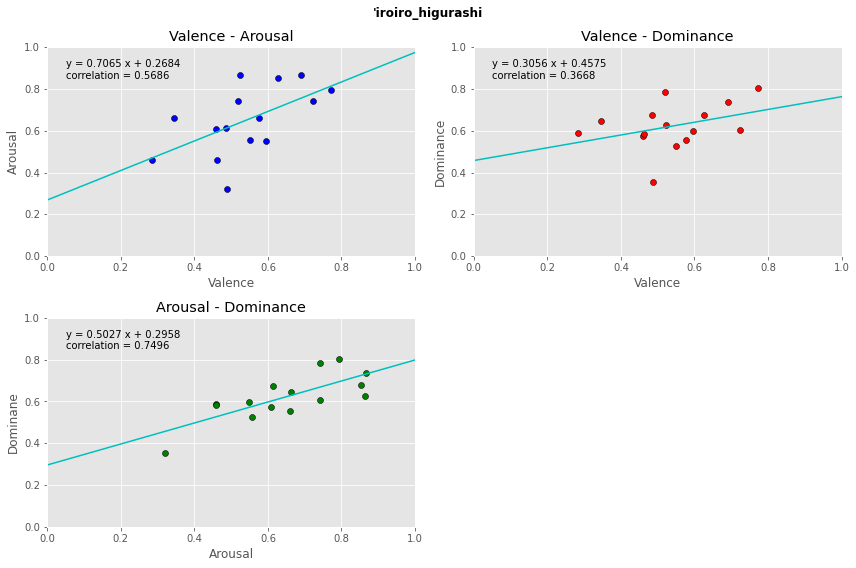

In [153]:
# Confirm Scatter plot
import matplotlib.style
from matplotlib.backends.backend_pdf import PdfPages
matplotlib.style.use('ggplot')

pdf = PdfPages(output_path + "All_plot.pdf")

for i in range(1,count_index+1):
#for i in range(1,2):
    #titles = grouped.get_group(i).index[0].rsplit('_',1)[0].rsplit("'",1)[1]
    titles = grouped.get_group(i).index[0].rsplit('_',1)[0]
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    #ax4 = fig.add_subplot(224)
    x = np.arange(0,1.1,0.01)
    
    a = df_out_cmp_describe["V-A_slope"][i-1]
    b = df_out_cmp_describe["V-A_intercept"][i-1]
    c = df_out_cmp_describe["V-A_corr"][i-1]
    ax1.scatter(grouped.get_group(i).Valence, grouped.get_group(i).Arousal, color='b',edgecolor='black')
    ax1.plot(x, a*x + b, color="c")
    ax1.text(0.05,0.85,"y = " + str(round(a,4)) + " x + " + str(round(b,4)) + "\n" + "correlation = " + str(round(c,4)), color="black")
    ax1.set_xlabel("Valence")
    ax1.set_ylabel("Arousal")
    ax1.set_xlim(0,1)
    ax1.set_ylim(0,1)
    ax1.set_title("Valence - Arousal")
    
    a = df_out_cmp_describe["V-D_slope"][i-1]
    b = df_out_cmp_describe["V-D_intercept"][i-1]
    c = df_out_cmp_describe["V-D_corr"][i-1]
    ax2.scatter(grouped.get_group(i).Valence, grouped.get_group(i).Dominance, color='r',edgecolor='black')
    ax2.plot(x, a*x + b, color="c")
    ax2.text(0.05,0.85,"y = " + str(round(a,4)) + " x + " + str(round(b,4)) + "\n" + "correlation = " + str(round(c,4)), color="black")
    ax2.set_xlabel("Valence")
    ax2.set_ylabel("Dominance")
    ax2.set_xlim(0,1)
    ax2.set_ylim(0,1)
    ax2.set_title("Valence - Dominance")
    
    a = df_out_cmp_describe["A-D_slope"][i-1]
    b = df_out_cmp_describe["A-D_intercept"][i-1]
    c = df_out_cmp_describe["A-D_corr"][i-1]
    ax3.scatter(grouped.get_group(i).Arousal, grouped.get_group(i).Dominance, color='g',edgecolor='black')
    ax3.plot(x, a*x + b, color="c")
    ax3.text(0.05,0.85,"y = " + str(round(a,4)) + " x + " + str(round(b,4)) + "\n" + "correlation = " + str(round(c,4)), color="black")
    ax3.set_xlabel("Arousal")
    ax3.set_ylabel("Dominane")
    ax3.set_xlim(0,1)
    ax3.set_ylim(0,1)
    ax3.set_title("Arousal - Dominance")
    
    fig.suptitle(titles,weight="heavy")
    plt.tight_layout()
    #fig.savefig(output_path + titles + "vad_scatterplot.png", bbox_inches="tight", pad_inches=0.05)
    pdf.savefig()
    
    #plt.show()
    if i == 1:
        plt.show()
    else:
        plt.cla()  # Axesをクリア
        plt.clf()  # figureをクリア
        plt.close()  # pltを閉じる

pdf.close()

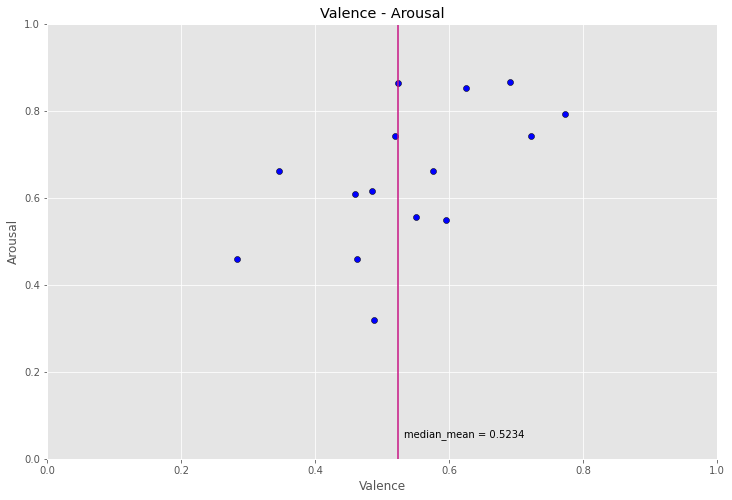

In [154]:
#Whole plot
import matplotlib.style
matplotlib.style.use('ggplot')

g = df_group_median["Valence"].mean()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax1.scatter(df_out_cmp["Valence"],df_out_cmp["Arousal"], color='b',edgecolor='black')
ax1.vlines(g,0,1,color="mediumvioletred")
ax1.text(g+0.01,0.05, "median_mean = " + str(round(g,4)), color="black")
ax1.set_xlabel("Valence")
ax1.set_ylabel("Arousal")
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_title("Valence - Arousal")

fig.savefig(output_path + "whole(0.2-0.8)" + "vad_scatterplot.png", bbox_inches="tight", pad_inches=0.05)
plt.show()

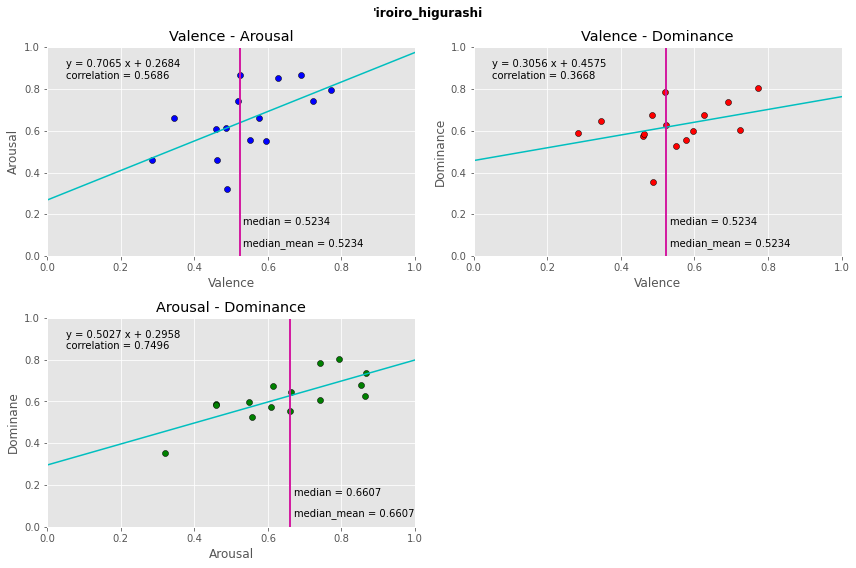

In [155]:
# median line
import matplotlib.style
from matplotlib.backends.backend_pdf import PdfPages
matplotlib.style.use('ggplot')

pdf = PdfPages(output_path + "median_plot.pdf")

df_group_median = grouped.median()
df_group_median
e = df_group_median["Valence"].mean()
f = df_group_median["Arousal"].mean()

for i in range(1,count_index+1):
#for i in range(1,2):
    #titles = grouped.get_group(i).index[0].rsplit('_',1)[0].rsplit("'",1)[1]
    titles = grouped.get_group(i).index[0].rsplit('_',1)[0]
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    #ax4 = fig.add_subplot(224)
    x = np.arange(0,1.1,0.01)
    
    a = df_out_cmp_describe["V-A_slope"][i-1]
    b = df_out_cmp_describe["V-A_intercept"][i-1]
    c = df_out_cmp_describe["V-A_corr"][i-1]
    d = df_group_median["Valence"][i]
    ax1.scatter(grouped.get_group(i).Valence, grouped.get_group(i).Arousal, color='b',edgecolor='black')
    ax1.plot(x, a*x + b, color="c")
    ax1.vlines(d,0,1,color="magenta")
    ax1.text(d+0.01,0.15, "median = " + str(round(d,4)), color="black")
    ax1.vlines(e,0,1,color="mediumvioletred")
    ax1.text(e+0.01,0.05, "median_mean = " + str(round(e,4)), color="black")
    ax1.text(0.05,0.85,"y = " + str(round(a,4)) + " x + " + str(round(b,4)) + "\n" + "correlation = " + str(round(c,4)), color="black")
    ax1.set_xlabel("Valence")
    ax1.set_ylabel("Arousal")
    ax1.set_xlim(0,1)
    ax1.set_ylim(0,1)
    ax1.set_title("Valence - Arousal")
    
    a = df_out_cmp_describe["V-D_slope"][i-1]
    b = df_out_cmp_describe["V-D_intercept"][i-1]
    c = df_out_cmp_describe["V-D_corr"][i-1]
    d = df_group_median["Valence"][i]
    ax2.scatter(grouped.get_group(i).Valence, grouped.get_group(i).Dominance, color='r',edgecolor='black')
    ax2.plot(x, a*x + b, color="c")
    ax2.vlines(d,0,1,color="magenta")
    ax2.text(d+0.01,0.15, "median = " + str(round(d,4)), color="black")
    ax2.vlines(e,0,1,color="mediumvioletred")
    ax2.text(e+0.01,0.05, "median_mean = " + str(round(e,4)), color="black")
    ax2.text(0.05,0.85,"y = " + str(round(a,4)) + " x + " + str(round(b,4)) + "\n" + "correlation = " + str(round(c,4)), color="black")
    ax2.set_xlabel("Valence")
    ax2.set_ylabel("Dominance")
    ax2.set_xlim(0,1)
    ax2.set_ylim(0,1)
    ax2.set_title("Valence - Dominance")
    
    a = df_out_cmp_describe["A-D_slope"][i-1]
    b = df_out_cmp_describe["A-D_intercept"][i-1]
    c = df_out_cmp_describe["A-D_corr"][i-1]
    d = df_group_median["Arousal"][i]
    ax3.scatter(grouped.get_group(i).Arousal, grouped.get_group(i).Dominance, color='g',edgecolor='black')
    ax3.plot(x, a*x + b, color="c")
    ax3.vlines(d,0,1,color="magenta")
    ax3.text(d+0.01,0.15, "median = " + str(round(d,4)), color="black")
    ax3.vlines(f,0,1,color="mediumvioletred")
    ax3.text(f+0.01,0.05, "median_mean = " + str(round(f,4)), color="black")
    ax3.text(0.05,0.85,"y = " + str(round(a,4)) + " x + " + str(round(b,4)) + "\n" + "correlation = " + str(round(c,4)), color="black")
    ax3.set_xlabel("Arousal")
    ax3.set_ylabel("Dominane")
    ax3.set_xlim(0,1)
    ax3.set_ylim(0,1)
    ax3.set_title("Arousal - Dominance")
    
    fig.suptitle(titles,weight="heavy")
    plt.tight_layout()
    #fig.savefig(output_path + titles + "vad_scatterplot.png", bbox_inches="tight", pad_inches=0.05)
    pdf.savefig()
    
    #plt.show()
    if i == 1:
        plt.show()
    else:
        plt.cla()  # Axesをクリア
        plt.clf()  # figureをクリア
        plt.close()  # pltを閉じる

pdf.close()

15
8
1:0,8
2:8,15


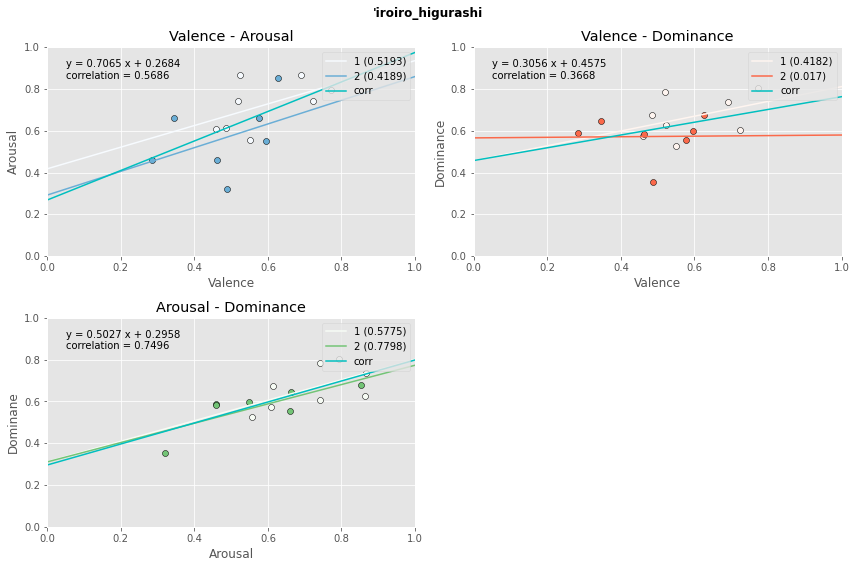

In [156]:
# Confirm Divided Scatter plot
#import matplotlib.style
#from matplotlib.backends.backend_pdf import PdfPages
matplotlib.style.use('ggplot')
pdf = PdfPages(output_path + "divided_plot.pdf")

for i in range(1,count_index+1):
    g = grouped.get_group(i)
    #titles = g.index[0].rsplit('_',1)[0].rsplit("'",1)[1]
    titles = g.index[0].rsplit('_',1)[0]
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    #ax4 = fig.add_subplot(224)
    x = np.arange(0,1.1,0.01)
    g_counts = len(g)
    g_medi = g_counts / y
    g_medi_int = math.ceil(g_medi)
    if i==1:
        print(g_counts)
        print(g_medi_int)
    
    a = df_out_cmp_describe["V-A_slope"][i-1]
    b = df_out_cmp_describe["V-A_intercept"][i-1]
    c = df_out_cmp_describe["V-A_corr"][i-1]

    sta_pos = 0
    end_pos = sta_pos + g_medi_int
    cmap_b = plt.get_cmap("Blues")
    color_counts = 0
    color_medi = 255 / y
    color_medi_int = math.ceil(color_medi)
    for j in range(y):
        if end_pos >= g_counts:
            end_pos = g_counts
        if i==1:
            print(str(j+1)+":"+str(sta_pos) + "," + str(end_pos))
        color_b = cmap_b(color_counts)
        ax1.scatter(g.Valence[sta_pos:end_pos], g.Arousal[sta_pos:end_pos], color=color_b,edgecolor='black')
        if g_counts == 1:
            va_slope, va_intercept, va_corr = np.nan,np.nan,np.nan
        else:
            va_slope, va_intercept, va_corr, _, _ = stats.linregress(g.Valence[sta_pos:end_pos], g.Arousal[sta_pos:end_pos])
        ax1.plot(x, va_slope*x + va_intercept, color=color_b, label=str(j+1)+" ("+str(round(va_corr,4))+")")
        sta_pos = sta_pos + g_medi_int
        end_pos = end_pos + g_medi_int
        color_counts = color_counts + color_medi_int
    
    #ax1.scatter(g.Valence, g.Arousal, color='b',edgecolor='black')
    ax1.plot(x, a*x + b, color="c", label='corr')
    ax1.text(0.05,0.85,"y = " + str(round(a,4)) + " x + " + str(round(b,4)) + "\n" + "correlation = " + str(round(c,4)), color="black")
    ax1.set_xlabel("Valence")
    ax1.set_ylabel("Arousal")
    ax1.set_xlim(0,1)
    ax1.set_ylim(0,1)
    ax1.set_title("Valence - Arousal")
    ax1.legend(loc="upper right", bbox_to_anchor=(0,0.95,1,0.05))
    
    a = df_out_cmp_describe["V-D_slope"][i-1]
    b = df_out_cmp_describe["V-D_intercept"][i-1]
    c = df_out_cmp_describe["V-D_corr"][i-1]
    
    sta_pos = 0
    end_pos = sta_pos + g_medi_int
    cmap_b = plt.get_cmap("Reds")
    color_counts = 0
    color_medi = 255 / y
    color_medi_int = math.ceil(color_medi)
    for j in range(y):
        if end_pos >= g_counts:
            end_pos = g_counts
        color_b = cmap_b(color_counts)
        ax2.scatter(g.Valence[sta_pos:end_pos], g.Dominance[sta_pos:end_pos], color=color_b,edgecolor='black')
        if g_counts == 1:
            vd_slope, vd_intercept, vd_corr = np.nan,np.nan,np.nan
        else:
            vd_slope, vd_intercept, vd_corr, _, _ = stats.linregress(g.Valence[sta_pos:end_pos], g.Dominance[sta_pos:end_pos])
        ax2.plot(x, vd_slope*x + vd_intercept, color=color_b, label=str(j+1)+" ("+str(round(vd_corr,4))+")")
        sta_pos = sta_pos + g_medi_int
        end_pos = end_pos + g_medi_int
        color_counts = color_counts + color_medi_int
    
    #ax2.scatter(g.Valence, g.Dominance, color='r',edgecolor='black')
    ax2.plot(x, a*x + b, color="c", label='corr')
    ax2.text(0.05,0.85,"y = " + str(round(a,4)) + " x + " + str(round(b,4)) + "\n" + "correlation = " + str(round(c,4)), color="black")
    ax2.set_xlabel("Valence")
    ax2.set_ylabel("Dominance")
    ax2.set_xlim(0,1)
    ax2.set_ylim(0,1)
    ax2.set_title("Valence - Dominance")
    ax2.legend(loc="upper right", bbox_to_anchor=(0,0.95,1,0.05))
    
    a = df_out_cmp_describe["A-D_slope"][i-1]
    b = df_out_cmp_describe["A-D_intercept"][i-1]
    c = df_out_cmp_describe["A-D_corr"][i-1]
    
    sta_pos = 0
    end_pos = sta_pos + g_medi_int
    cmap_b = plt.get_cmap("Greens")
    color_counts = 0
    color_medi = 255 / y
    color_medi_int = math.ceil(color_medi)
    for j in range(y):
        if end_pos >= g_counts:
            end_pos = g_counts
        color_b = cmap_b(color_counts)
        ax3.scatter(g.Arousal[sta_pos:end_pos], g.Dominance[sta_pos:end_pos], color=color_b,edgecolor='black')
        if g_counts == 1:
            ad_slope, ad_intercept, ad_corr = np.nan,np.nan,np.nan
        else:
            ad_slope, ad_intercept, ad_corr, _, _ = stats.linregress(g.Arousal[sta_pos:end_pos], g.Dominance[sta_pos:end_pos])
        ax3.plot(x, ad_slope*x + ad_intercept, color=color_b, label=str(j+1)+" ("+str(round(ad_corr,4))+")")
        sta_pos = sta_pos + g_medi_int
        end_pos = end_pos + g_medi_int
        color_counts = color_counts + color_medi_int
    
    #ax3.scatter(g.Arousal, g.Dominance, color='y',edgecolor='black')
    ax3.plot(x, a*x + b, color="c", label='corr')
    ax3.text(0.05,0.85,"y = " + str(round(a,4)) + " x + " + str(round(b,4)) + "\n" + "correlation = " + str(round(c,4)), color="black")
    ax3.set_xlabel("Arousal")
    ax3.set_ylabel("Dominane")
    ax3.set_xlim(0,1)
    ax3.set_ylim(0,1)
    ax3.set_title("Arousal - Dominance")
    ax3.legend(loc="upper right", bbox_to_anchor=(0,0.95,1,0.05))
    
    fig.suptitle(titles,weight="heavy")
    plt.tight_layout()
    #fig.savefig(output_path + titles + "vad_scatterplot.png", bbox_inches="tight", pad_inches=0.05)
    pdf.savefig()
    
    #plt.show()
    if i == 1:
        plt.show()
    else:
        plt.cla()  # Axesをクリア
        plt.clf()  # figureをクリア
        plt.close()  # pltを閉じる

pdf.close()

In [157]:
# pip install pingouin
# conda install pingouin

In [158]:
# pip install --upgrade pingouin

In [159]:
import pingouin as pg

In [160]:
# dfdf = pg.read_dataset('rm_corr')
# dfdf

In [161]:
df_out_cmp_2

,Valence,Arousal,Dominance,count_index
'iroiro_higurashi_001.wav',0.772614,0.793260,0.804540,1
'iroiro_higurashi_002.wav',0.690431,0.867359,0.737721,1
'iroiro_higurashi_003.wav',0.485323,0.614954,0.673315,1
'iroiro_higurashi_004.wav',0.523401,0.864825,0.626685,1
'iroiro_higurashi_005.wav',0.550778,0.556022,0.526123,1
'iroiro_higurashi_006.wav',0.460157,0.609133,0.574562,1
'iroiro_higurashi_007.wav',0.722560,0.741564,0.604771,1
'iroiro_higurashi_008.wav',0.519585,0.742112,0.783674,1
'iroiro_higurashi_009.wav',0.345792,0.662298,0.646616,1
'iroiro_higurashi_010.wav',0.283795,0.458367,0.589562,1


In [162]:
pg.rm_corr(data=df_out_cmp_2, x='Valence', y='Arousal', subject='count_index')

ValueError: rm_corr requires at least 3 unique subjects.

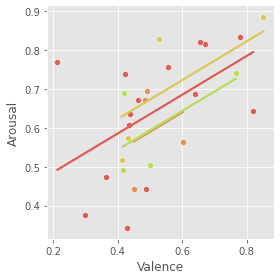

In [ ]:
h = pg.plot_rm_corr(data=df_out_cmp_2, x='Valence', y='Arousal', subject='count_index')

In [ ]:
pg.rm_corr(data=df_out_cmp_2, x='Valence', y='Dominance', subject='count_index')

,r,dof,pval,CI95%,power
rm_corr,0.415677,22,0.043368,"[0.01, 0.7]",0.541287


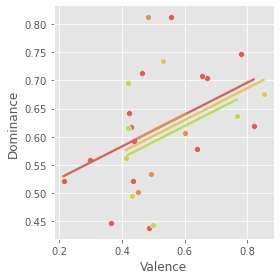

In [ ]:
l = pg.plot_rm_corr(data=df_out_cmp_2, x='Valence', y='Dominance', subject='count_index')

In [ ]:
pg.rm_corr(data=df_out_cmp_2, x='Arousal', y='Dominance', subject='count_index')

,r,dof,pval,CI95%,power
rm_corr,0.629888,22,0.000972,"[0.3, 0.82]",0.932427


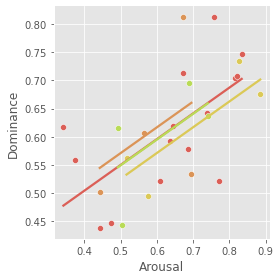

In [ ]:
m = pg.plot_rm_corr(data=df_out_cmp_2, x='Arousal', y='Dominance', subject='count_index')

In [ ]:
df_out_cmp.corr()

,Valence,Arousal,Dominance
Valence,1.000000,0.532342,0.412782
Arousal,0.532342,1.000000,0.620696
Dominance,0.412782,0.620696,1.000000


In [163]:
os.system("osascript -e 'display notification \"NN Learning finished !!\"'")

sh: osascript: command not found


32512

In [164]:
from line_notify import line_notice
line_notice().send_messages('{}の予測が終了しました!!👍'.format(output_file))

Messege : 
emo&var05_model_results_samplevoice_soxshudou01の予測が終了しました!!👍
Response : 成功
